download: s3://openneuro.org/ds003061/sub-001/eeg/sub-001_task-P300_run-1_eeg.set to ./sub-001_task-P300_run-1_eeg.set


<ipython-input-14-626f10d16731>:30: RuntimeWarning: Unknown types found, setting as type EEG:
temp: ['Temp']
  raw = mne.io.read_raw_eeglab(data_path, preload=True)
<ipython-input-14-626f10d16731>:30: RuntimeWarning: Not setting positions of 14 gsr/misc/resp channels found in montage:
['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Plet']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(data_path, preload=True)


EEG data loaded successfully!
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 65 EEG, 11 misc, 2 Galvanic skin response, 1 Respiration monitoring channel
 custom_ref_applied: False
 dig: 68 items (3 Cardinal, 65 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 79
 projs: []
 sfreq: 256.0 Hz
>


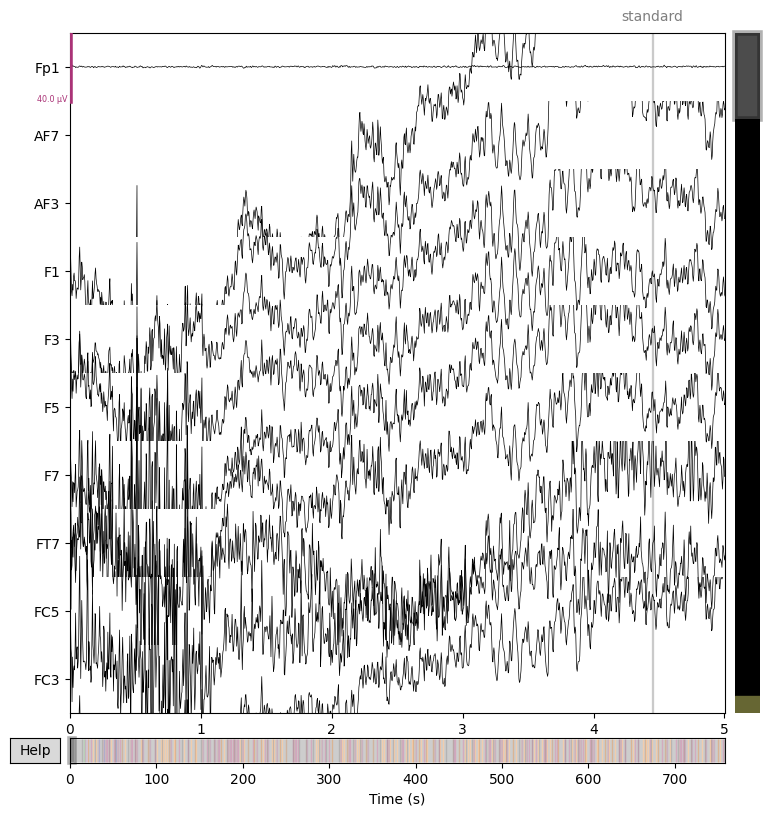

Raw EEG plot saved to /content/raw_eeg_plot.png
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Data filtered between 0.5 Hz and 40 Hz
Channel types and montage updated
Fitting ICA to data using 64 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.6s finished
<ipython-input-14-626f10d16731>:50: RuntimeWarning: The unit for channel(s) Temp has changed from V to NA.
  raw.set_channel_types({
<ipython-input-14-626f10d16731>:50: RuntimeWarning: The unit for channel(s) EXG1, EXG2, EXG3, EXG4 has changed from NA to V.
  raw.set_channel_types({


Selecting by number: 20 components
Fitting ICA took 11.6s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Artifacts removed using ICA


<Figure size 640x480 with 0 Axes>

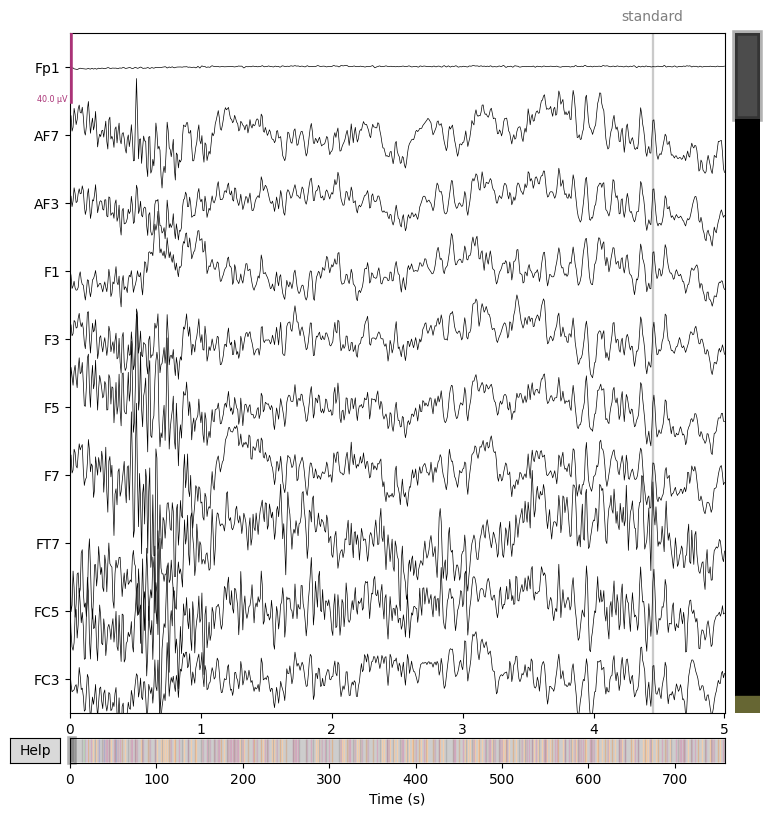

Cleaned EEG plot saved to /content/cleaned_eeg_plot.png
Used Annotations descriptions: [np.str_('ignore'), np.str_('noise'), np.str_('noise_with_reponse'), np.str_('oddball'), np.str_('oddball_with_reponse'), np.str_('response'), np.str_('standard')]
Events extracted from annotations:
Event ID mapping: {np.str_('ignore'): 1, np.str_('noise'): 2, np.str_('noise_with_reponse'): 3, np.str_('oddball'): 4, np.str_('oddball_with_reponse'): 5, np.str_('response'): 6, np.str_('standard'): 7}
First few events: [[1139    0    7]
 [1346    0    7]
 [1604    0    7]
 [1876    0    7]
 [2138    0    7]]
Raw event distribution:
{np.str_('ignore'): np.int64(3), np.str_('noise'): np.int64(111), np.str_('noise_with_reponse'): np.int64(1), np.str_('oddball'): np.int64(1), np.str_('oddball_with_reponse'): np.int64(112), np.str_('response'): np.int64(113), np.str_('standard'): np.int64(522)}
Not setting metadata
746 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline 

<Figure size 640x480 with 0 Axes>

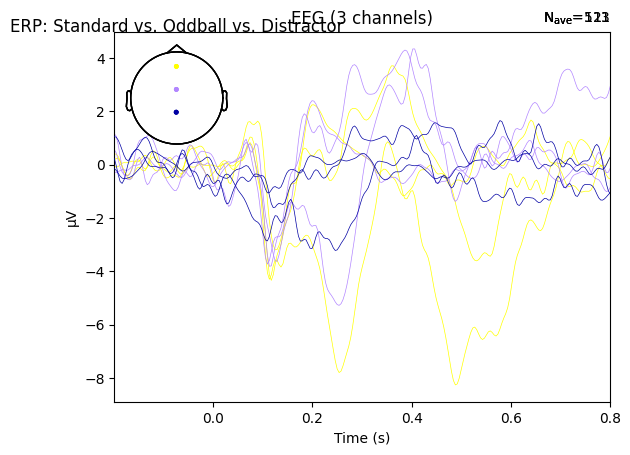

In [14]:
# Step 1: Install AWS CLI and MNE-Python
!pip install awscli
!pip install mne
!pip install imbalanced-learn  # For SMOTE
!pip install PyWavelets  #  wavelet transform

# Step 2: Import required libraries
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from mne.time_frequency import psd_array_multitaper
import os
from imblearn.over_sampling import SMOTE
import pywt  # For wavelet transform

# Step 3: Download a single EEG file from ds003061 (sub-001, run-1, .set format)
!aws s3 cp --no-sign-request s3://openneuro.org/ds003061/sub-001/eeg/sub-001_task-P300_run-1_eeg.set /content/sub-001_task-P300_run-1_eeg.set

# Step 4: Verify and load EEG data
data_path = '/content/sub-001_task-P300_run-1_eeg.set'
try:
    if os.path.exists(data_path):
        raw = mne.io.read_raw_eeglab(data_path, preload=True)
        print("EEG data loaded successfully!")
    else:
        raise FileNotFoundError(f"File not found at {data_path}. Please check if the download succeeded.")
except Exception as e:
    print(f"Error loading EEG data: {e}")
    print("Ensure the AWS CLI command downloaded the file correctly. Run '!aws s3 ls --no-sign-request s3://openneuro.org/ds003061/sub-001/eeg/' to check available files.")
    raise

# Step 5: Basic data inspection
print(raw.info)
raw.plot(duration=5, n_channels=10)
plt.savefig('/content/raw_eeg_plot.png')
print("Raw EEG plot saved to /content/raw_eeg_plot.png")

# Step 6: Apply a bandpass filter to clean the data
raw.filter(l_freq=0.5, h_freq=40.0)
print("Data filtered between 0.5 Hz and 40 Hz")

# Step 7: Fix channel types and apply montage
raw.set_channel_types({
    'Temp': 'misc',
    'EXG1': 'eog', 'EXG2': 'eog', 'EXG3': 'eog', 'EXG4': 'eog',
    'EXG5': 'misc', 'EXG6': 'misc', 'EXG7': 'misc', 'EXG8': 'misc',
    'GSR1': 'gsr', 'GSR2': 'gsr', 'Erg1': 'misc', 'Erg2': 'misc',
    'Resp': 'resp', 'Plet': 'misc'
})
raw.set_montage('standard_1020')
print("Channel types and montage updated")

# Step 8: Remove artifacts using ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=42)
ica.fit(raw)
ica.exclude = [0, 1]  # Manually selected components for eye blinks
ica.apply(raw)
print("Artifacts removed using ICA")

# Step 9: Save a plot of the cleaned data
raw.plot(duration=5, n_channels=10)
plt.savefig('/content/cleaned_eeg_plot.png')
print("Cleaned EEG plot saved to /content/cleaned_eeg_plot.png")

# Step 10: Extract events from annotations
events, event_id = mne.events_from_annotations(raw)
print("Events extracted from annotations:")
print(f"Event ID mapping: {event_id}")
print(f"First few events: {events[:5]}")

# Step 11: Check raw event distribution before epoching
raw_event_counts = {name: (events[:, 2] == id_).sum() for name, id_ in event_id.items()}
print("Raw event distribution:")
print(raw_event_counts)

# Step 12: Create epochs with preload=True, combining oddball and oddball_with_reponse
event_id_subset = {
    'standard': event_id['standard'],
    'oddball': [event_id['oddball'], event_id['oddball_with_reponse']],  # Fixed typo
    'distractor': event_id['noise']
}
events_adjusted = events.copy()
oddball_ids = [event_id['oddball'], event_id['oddball_with_reponse']]  # Fixed typo
events_adjusted[np.isin(events_adjusted[:, 2], oddball_ids), 2] = event_id['oddball']
event_id_subset_adjusted = {
    'standard': event_id['standard'],
    'oddball': event_id['oddball'],
    'distractor': event_id['noise']
}
epochs = mne.Epochs(raw, events_adjusted, event_id=event_id_subset_adjusted, tmin=-0.2, tmax=0.8, baseline=(None, 0), preload=True)
print(f"Epochs created: {len(epochs)} epochs")

# Step 13: Check event distribution and dropped epochs
event_counts = {name: (epochs.events[:, 2] == id_).sum() for name, id_ in event_id_subset_adjusted.items()}
print("Event distribution in epochs:")
print(event_counts)
print("Dropped epochs log:")
print(epochs.drop_log)

# Step 14: Plot ERP (P300) for oddball vs. standard vs. distractor
evoked_standard = epochs['standard'].average()
evoked_oddball = epochs['oddball'].average()
evoked_distractor = epochs['distractor'].average()
fig, ax = plt.subplots()
evoked_standard.plot(picks=['Fz', 'Cz', 'Pz'], axes=ax, show=False)
evoked_oddball.plot(picks=['Fz', 'Cz', 'Pz'], axes=ax, show=False)
evoked_distractor.plot(picks=['Fz', 'Cz', 'Pz'], axes=ax, show=False)
plt.title("ERP: Standard vs. Oddball vs. Distractor")
plt.savefig('/content/erp_plot.png')
print("ERP plot saved to /content/erp_plot.png")

Number of epochs for classification: 634
Number of Standard epochs: 521
Number of Oddball epochs: 113
After SMOTE - Standard: 521, Oddball: 521
Training set: 833 samples, Test set: 209 samples
Training Standard: 416, Training Oddball: 417
Test Standard: 105, Test Oddball: 104
Best SVM parameters: {'C': 10, 'gamma': 0.1}
Test Classification Accuracy (SVM): 0.92
              precision    recall  f1-score   support

    Standard       0.95      0.89      0.92       105
     Oddball       0.89      0.95      0.92       104

    accuracy                           0.92       209
   macro avg       0.92      0.92      0.92       209
weighted avg       0.92      0.92      0.92       209

SVM Cross-validation F1-macro scores: [0.90412844 0.92314764 0.95664961 0.97112982 0.94705542]
SVM Mean CV F1-macro: 0.94 (+/- 0.05)
Best Random Forest parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Test Classification Accuracy (Random Forest): 0.90
              precision    recal

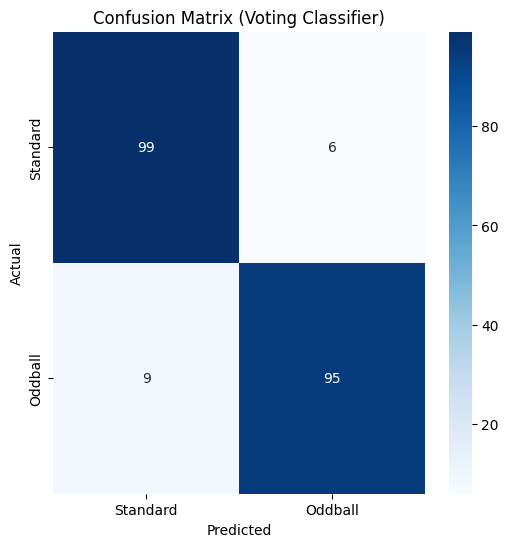

In [13]:
# Step 16: Import additional libraries
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
import pywt

# Step 17: Enhanced feature extraction with additional features
channels = ['Fz', 'Cz', 'Pz']
data = epochs.get_data(picks=channels)  # Shape: (n_epochs, n_channels, n_times)

# 1. P300 mean amplitude (250-500 ms)
time_idx_p300 = (epochs.times >= 0.25) & (epochs.times <= 0.5)
p300_mean = data[:, :, time_idx_p300].mean(axis=2)  # Shape: (n_epochs, n_channels)

# 2. P300 peak latency
p300_max_time = epochs.times[time_idx_p300][data[:, :, time_idx_p300].argmax(axis=2)]

# 3. N200 mean amplitude (100-250 ms)
time_idx_n200 = (epochs.times >= 0.1) & (epochs.times <= 0.25)
n200_mean = data[:, :, time_idx_n200].mean(axis=2)

# 4. PSD in alpha band (8-12 Hz)
sfreq = raw.info['sfreq']
psd, freqs = psd_array_multitaper(data, sfreq=sfreq, fmin=8, fmax=12, verbose=False)
alpha_power = psd.mean(axis=2)

# 5. PSD in theta band (4-8 Hz)
psd_theta, freqs_theta = psd_array_multitaper(data, sfreq=sfreq, fmin=4, fmax=8, verbose=False)
theta_power = psd_theta.mean(axis=2)

# 6. Wavelet coefficients using Daubechies wavelet (db4)
wavelet = 'db4'
coeffs = []
for epoch in data:
    channel_coeffs = []
    for channel in epoch:
        cA, cD = pywt.dwt(channel, wavelet)
        channel_coeffs.append(np.mean(cA))  # Use approximation coefficients
    coeffs.append(channel_coeffs)
wavelet_coeffs = np.array(coeffs)

# Combine features
features = np.hstack((p300_mean, p300_max_time, n200_mean, alpha_power, theta_power, wavelet_coeffs))
if np.isnan(features).any():
    print("Warning: NaN values found in features. Replacing with zeros.")
    features = np.nan_to_num(features, nan=0.0)

# Step 18: Prepare data for classification (oddball vs. standard)
labels = np.array([
    1 if e == event_id['oddball']
    else 0 if e == event_id['standard']
    else -1 for e in epochs.events[:, 2]
])
keep_idx = labels != -1
features = features[keep_idx]
labels = labels[keep_idx]
print(f"Number of epochs for classification: {len(labels)}")
print(f"Number of Standard epochs: {(labels == 0).sum()}")
print(f"Number of Oddball epochs: {(labels == 1).sum()}")

# Step 19: Address class imbalance with SMOTE
smote = SMOTE(random_state=42)
features_resampled, labels_resampled = smote.fit_resample(features, labels)
print(f"After SMOTE - Standard: {(labels_resampled == 0).sum()}, Oddball: {(labels_resampled == 1).sum()}")

# Step 20: Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_resampled)

# Step 21: Split data
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, labels_resampled, test_size=0.2, random_state=42, stratify=labels_resampled
)
print(f"Training set: {len(y_train)} samples, Test set: {len(y_test)} samples")
print(f"Training Standard: {(y_train == 0).sum()}, Training Oddball: {(y_train == 1).sum()}")
print(f"Test Standard: {(y_test == 0).sum()}, Test Oddball: {(y_test == 1).sum()}")

# Step 22: Train SVM with hyperparameter tuning
param_grid_svm = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.1]}
svm = GridSearchCV(SVC(kernel='rbf', class_weight='balanced', random_state=42), param_grid_svm, cv=5)
svm.fit(X_train, y_train)
print(f"Best SVM parameters: {svm.best_params_}")
y_pred_svm = svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Test Classification Accuracy (SVM): {accuracy_svm:.2f}")
print(classification_report(y_test, y_pred_svm, target_names=['Standard', 'Oddball']))
scores_svm = cross_val_score(svm.best_estimator_, features_scaled, labels_resampled, cv=5, scoring='f1_macro')
print(f"SVM Cross-validation F1-macro scores: {scores_svm}")
print(f"SVM Mean CV F1-macro: {scores_svm.mean():.2f} (+/- {scores_svm.std() * 2:.2f})")

# Step 23: Train Random Forest with hyperparameter tuning
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
rf = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42), param_grid_rf, cv=5)
rf.fit(X_train, y_train)
print(f"Best Random Forest parameters: {rf.best_params_}")
y_pred_rf = rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Test Classification Accuracy (Random Forest): {accuracy_rf:.2f}")
print(classification_report(y_test, y_pred_rf, target_names=['Standard', 'Oddball']))
scores_rf = cross_val_score(rf.best_estimator_, features_scaled, labels_resampled, cv=5, scoring='f1_macro')
print(f"Random Forest Cross-validation F1-macro scores: {scores_rf}")
print(f"Random Forest Mean CV F1-macro: {scores_rf.mean():.2f} (+/- {scores_rf.std() * 2:.2f})")

# Step 24: Ensemble with Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('svm', svm.best_estimator_),
    ('rf', rf.best_estimator_)
], voting='hard')
voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)
accuracy_voting = accuracy_score(y_test, y_pred_voting)
print(f"Test Classification Accuracy (Voting Classifier): {accuracy_voting:.2f}")
print(classification_report(y_test, y_pred_voting, target_names=['Standard', 'Oddball']))
scores_voting = cross_val_score(voting_clf, features_scaled, labels_resampled, cv=5, scoring='f1_macro')
print(f"Voting Classifier Cross-validation F1-macro scores: {scores_voting}")
print(f"Voting Classifier Mean CV F1-macro: {scores_voting.mean():.2f} (+/- {scores_voting.std() * 2:.2f})")

# Step 25: Plot confusion matrix for the best model
best_pred = y_pred_voting
cm = confusion_matrix(y_test, best_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Standard', 'Oddball'], yticklabels=['Standard', 'Oddball'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Voting Classifier)')
plt.savefig('/content/confusion_matrix.png')
print("Confusion matrix saved to /content/confusion_matrix.png")

# Step 26: Download all plots
print("Download the following plots from Colab's Files tab:")
print("- /content/cleaned_eeg_plot.png")
print("- /content/erp_plot.png")
print("- /content/confusion_matrix.png")